In [26]:
import pydicom
from itertools import islice
import numpy as np
import struct

In [2]:
dataset = pydicom.dcmread('anonymous_ecg.dcm')

# 'anonymous_ecg.dcm' was taken from https://github.com/marcodebe/dicom-ecg-plot

In [16]:
print(str(dataset)[:800])

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 176
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: 12-lead ECG Waveform Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.20029.40.20130125105919.5407.1.1
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.76.13.1.1.1.1
(0002, 0013) Implementation Version Name         SH: 'AISDWAM40'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0012) Instance Creation Date              DA: '20130125'
(0008, 0013) Instance Creation Time              TM: 


In [4]:
dataset.file_meta

(0002, 0000) File Meta Information Group Length  UL: 176
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: 12-lead ECG Waveform Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.20029.40.20130125105919.5407.1.1
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.76.13.1.1.1.1
(0002, 0013) Implementation Version Name         SH: 'AISDWAM40'

In [5]:
dataset.file_meta[(0x0002, 0x0013)]

(0002, 0013) Implementation Version Name         SH: 'AISDWAM40'

In [6]:
dataset[0x0008, 0x0005]  # note, keys are hexadecimals

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'

In [7]:
dataset[0x0008, 0x0005].value

'ISO_IR 100'

In [8]:
dataset.SpecificCharacterSet  # here we access the same entry by name

'ISO_IR 100'

In [9]:
dataset.WaveformSequence  # this entry is getting us closer to the actual readings

<Sequence, length 2>

In [10]:
# adapting code from https://github.com/marcodebe/dicom-ecg-plot

sequence_item = dataset.WaveformSequence[0]

assert (sequence_item.WaveformSampleInterpretation == 'SS')
assert (sequence_item.WaveformBitsAllocated == 16)

channel_definitions = sequence_item.ChannelDefinitionSequence
wavewform_data = sequence_item.WaveformData
channels_no = sequence_item.NumberOfWaveformChannels
samples = sequence_item.NumberOfWaveformSamples
sampling_frequency = sequence_item.SamplingFrequency
duration = samples / sampling_frequency

In [37]:
sequence_item.WaveformData[:30]

b'P\x00Z\x00\n\x00\xab\xff#\x002\x00(\x00\x0f\x00\xf6\xff\xec\xff\xc9\xff\xd8\xffA\x00U\x00\x14\x00'

In [17]:
channels_no

12

In [18]:
channel_definitions[0]

(003a, 0208)  Channel Source Sequence   1 item(s) ---- 
   (0008, 0100) Code Value                          SH: '5.6.3-9-1'
   (0008, 0102) Coding Scheme Designator            SH: 'SCPECG'
   (0008, 0103) Coding Scheme Version               SH: '1.3'
   (0008, 0104) Code Meaning                        LO: 'Lead I (Einthoven)'
   ---------
(003a, 0210) Channel Sensitivity                 DS: "1.25"
(003a, 0211)  Channel Sensitivity Units Sequence   1 item(s) ---- 
   (0008, 0100) Code Value                          SH: 'uV'
   (0008, 0102) Coding Scheme Designator            SH: 'UCUM'
   (0008, 0103) Coding Scheme Version               SH: '1.4'
   (0008, 0104) Code Meaning                        LO: 'microvolt'
   ---------
(003a, 0212) Channel Sensitivity Correction Fact DS: "1.0"
(003a, 0213) Channel Baseline                    DS: "0.0"
(003a, 0215) Channel Sample Skew                 DS: "0.0"
(003a, 021a) Waveform Bits Stored                US: 16
(003a, 0220) Filter Low Frequenc

In [30]:
# adapting code from https://github.com/marcodebe/dicom-ecg-plot

def signals():
    factor = np.zeros(channels_no) + 1
    baseln = np.zeros(channels_no)
    units = []
    for idx in range(channels_no):
        definition = channel_definitions[idx]

        assert (definition.WaveformBitsStored == 16)

        if definition.get('ChannelSensitivity'):
            factor[idx] = (
                float(definition.ChannelSensitivity) *
                float(definition.ChannelSensitivityCorrectionFactor)
            )

        if definition.get('ChannelBaseline'):
            baseln[idx] = float(definition.get('ChannelBaseline'))

        units.append(
            definition.ChannelSensitivityUnitsSequence[0].CodeValue
        )

    unpack_fmt = '<%dh' % (len(wavewform_data) / 2)
    unpacked_waveform_data = struct.unpack(unpack_fmt, wavewform_data)
    signals = np.asarray(
        unpacked_waveform_data,
        dtype=np.float32).reshape(
        samples,
        channels_no).transpose()

    for channel in range(channels_no):
        signals[channel] = (
            (signals[channel] + baseln[channel]) * factor[channel]
        )

    high = 40.0

    # conversion factor to obtain millivolts values
    millivolts = {'uV': 1000.0, 'mV': 1.0}

#     for i, signal in enumerate(signals):
#         signals[i] = butter_lowpass_filter(
#             np.asarray(signal),
#             high,
#             self.sampling_frequency,
#             order=2
#         ) / millivolts[units[i]]

    return signals

In [32]:
raw_signals_extracted = signals()

In [33]:
raw_signals_extracted

array([[ 100.  ,   81.25,   62.5 , ...,   25.  ,   21.25,   25.  ],
       [ 112.5 ,  106.25,  100.  , ...,  131.25,  137.5 ,  137.5 ],
       [  12.5 ,   25.  ,   37.5 , ...,  106.25,  116.25,  112.5 ],
       ...,
       [ -25.  ,  -25.  ,  -25.  , ..., -137.5 , -137.5 , -137.5 ],
       [ -68.75,  -75.  ,  -81.25, ..., -150.  , -150.  , -150.  ],
       [ -50.  ,  -50.  ,  -50.  , ..., -100.  , -106.25, -112.5 ]],
      dtype=float32)

In [34]:
raw_signals_extracted.shape

(12, 10000)

In [43]:
import pandas as pd
from sktime.utils.plotting.forecasting import plot_ys

%matplotlib inline

In [44]:
y = pd.Series(raw_signals_extracted[0, :])

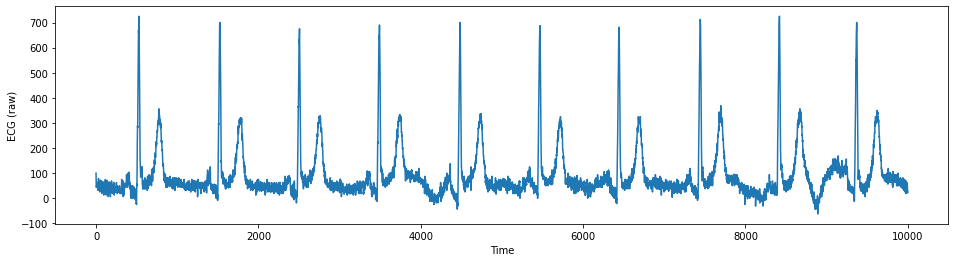

In [46]:
fig, ax = plot_ys(y)
ax.set(xlabel="Time", ylabel="ECG (raw)");